<a href="https://colab.research.google.com/github/powersimmani/AIWS2023/blob/main/Feature_Importance_of_titanic_dataset_with_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Top 4% with ensemble modeling
### **Yassine Ghouzam, PhD**
#### 13/07/2017

* **1 Introduction**
* **2 Load and check data**
    * 2.1 load data
    * 2.2 Outlier detection
    * 2.3 joining train and test set
    * 2.4 check for null and missing values
* **3 Feature analysis**
    * 3.1 Numerical values
    * 3.2 Categorical values
* **4 Filling missing Values**
    * 4.1 Age
* **5 Feature engineering**
    * 5.1 Name/Title
    * 5.2 Family Size
    * 5.3 Cabin
    * 5.4 Ticket
* **6 Modeling**
    * 6.1 Simple modeling
        * 6.1.1 Cross validate models
        * 6.1.2 Hyperparamater tunning for best models
        * 6.1.3 Plot learning curves
        * 6.1.4 Feature importance of the tree based classifiers
    * 6.2 Ensemble modeling
        * 6.2.1 Combining models
    * 6.3 Prediction
        * 6.3.1 Predict and Submit results
    

## 1. Introduction

This is my first kernel at Kaggle. I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.

This script follows three main parts:

* **Feature analysis**
* **Feature engineering**
* **Modeling**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')


## 2. Load and check data
### 2.1 Load data

In [ ]:
# Load data
##### Load train and Test set

train = pd.read_csv("/content/sample_data/train.csv")
test = pd.read_csv("/content/sample_data/test.csv")
IDtest = test["PassengerId"]
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [ ]:
train.info()  # 모든 column, dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train.describe()  # 숫자인 feature만 가져와서 mean, min, max 등등 보여줌

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [ ]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

### 2.2 Outlier detection

In [ ]:
# Outlier detection

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), i choosed to manage them.

I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).


I decided to detect outliers from the numerical values features (Age, SibSp, Parch and Fare). Then, I considered outliers as rows that have at least two outlied numerical values.

In [ ]:
train.loc[Outliers_to_drop] # Show the outliers rows

PassengerId  Survived  Pclass                               Name     Sex  \
27            28         0       1     Fortune, Mr. Charles Alexander    male   
88            89         1       1         Fortune, Miss. Mabel Helen  female   
159          160         0       3         Sage, Master. Thomas Henry    male   
180          181         0       3       Sage, Miss. Constance Gladys  female   
201          202         0       3                Sage, Mr. Frederick    male   
324          325         0       3           Sage, Mr. George John Jr    male   
341          342         1       1     Fortune, Miss. Alice Elizabeth  female   
792          793         0       3            Sage, Miss. Stella Anna  female   
846          847         0       3           Sage, Mr. Douglas Bullen    male   
863          864         0       3  Sage, Miss. Dorothy Edith "Dolly"  female   

      Age  SibSp  Parch    Ticket    Fare        Cabin Embarked  
27   19.0      3      2     19950  263.00  C23 C25 C27        S  
88   23.0      3      2     19950  263.00  C23 C25 C27        S  
159   NaN      8      2  CA. 2343   69.55          NaN        S  
180   NaN      8      2  CA. 2343   69.55          NaN        S  
201   NaN      8      2  CA. 2343   69.55          NaN        S  
324   NaN      8      2  CA. 2343   69.55          NaN        S  
341  24.0      3      2     19950  263.00  C23 C25 C27        S  
792   NaN      8      2  CA. 2343   69.55          NaN        S  
846   NaN      8      2  CA. 2343   69.55          NaN        S  
863   NaN      8      2  CA. 2343   69.55          NaN        S

We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare

The 7 others have very high values of SibSP.

In [ ]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 joining train and test set

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
print(train_len)
print(dataset.describe())

881
       PassengerId    Survived       Pclass          Age        SibSp  \
count  1299.000000  881.000000  1299.000000  1043.000000  1299.000000   
mean    657.093149    0.385925     2.294072    29.903806     0.452656   
std     377.743244    0.487090     0.837150    14.427548     0.879416   
min       1.000000    0.000000     1.000000     0.170000     0.000000   
25%     331.500000    0.000000     2.000000    21.000000     0.000000   
50%     657.000000    0.000000     3.000000    28.000000     0.000000   
75%     984.500000    1.000000     3.000000    39.000000     1.000000   
max    1309.000000    1.000000     3.000000    80.000000     8.000000   

             Parch         Fare  
count  1299.000000  1298.000000  
mean      0.372594    32.569058  
std       0.857157    50.694652  
min       0.000000     0.000000  
25%       0.000000     7.895800  
50%       0.000000    14.454200  
75%       0.000000    30.646850  
max       9.000000   512.329200  


I join train and test datasets to obtain the same number of features during categorical conversion (See feature engineering).

### 2.4 check for null and missing values

In [ ]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age and Cabin features have an important part of missing values.

**Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and test set)**

In [ ]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [ ]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
### Summarize data
# Summarie and statistics
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   881.000000  881.000000  881.000000  711.000000  881.000000   
mean    446.713961    0.385925    2.307605   29.731603    0.455165   
std     256.617021    0.487090    0.835055   14.547835    0.871571   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     226.000000    0.000000    2.000000   20.250000    0.000000   
50%     448.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.000000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    5.000000   

            Parch        Fare  
count  881.000000  881.000000  
mean     0.363224   31.121566  
std      0.791839   47.996249  
min      0.000000    0.000000  
25%      0.000000    7.895800  
50%      0.000000   14.454200  
75%      0.000000   30.500000  
max      6.000000  512.329200

## 3. Feature analysis

### 3.1 Numerical values

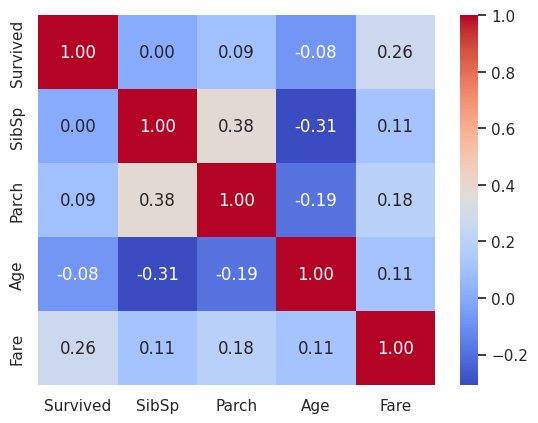

In [ ]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features

#### SibSP

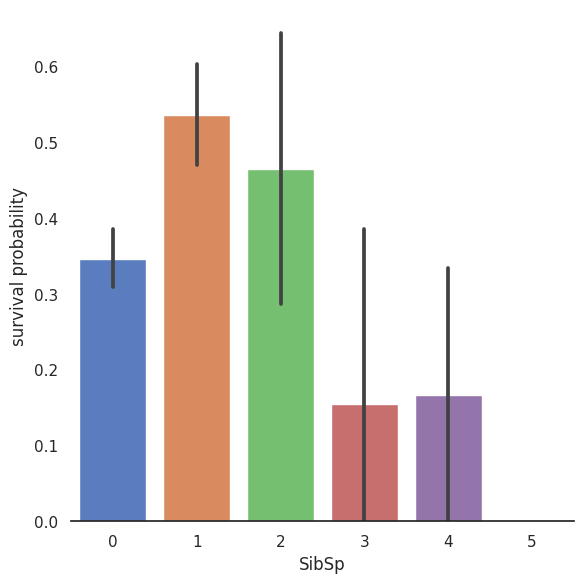

In [ ]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar", height = 6 ,
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive

Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)

#### Parch

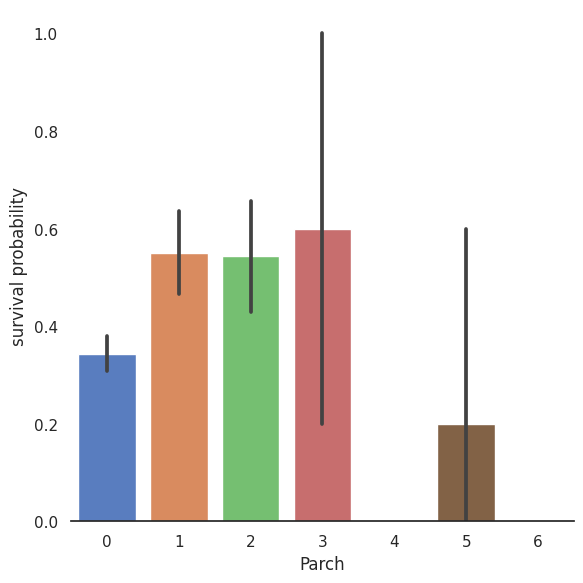

In [ ]:
# Explore Parch feature vs Survived
g  = sns.catplot(x="Parch",y="Survived",data=train,kind="bar", height = 6 ,
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children

#### Age

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


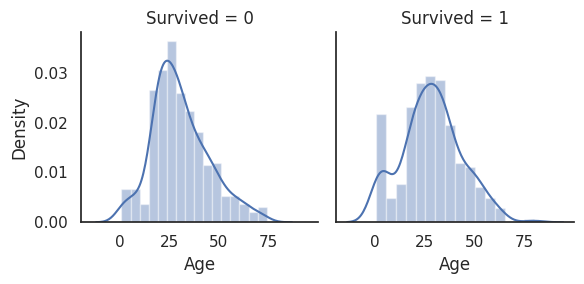

In [ ]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

<ipython-input-22-60c53fc48d52>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
<ipython-input-22-60c53fc48d52>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)


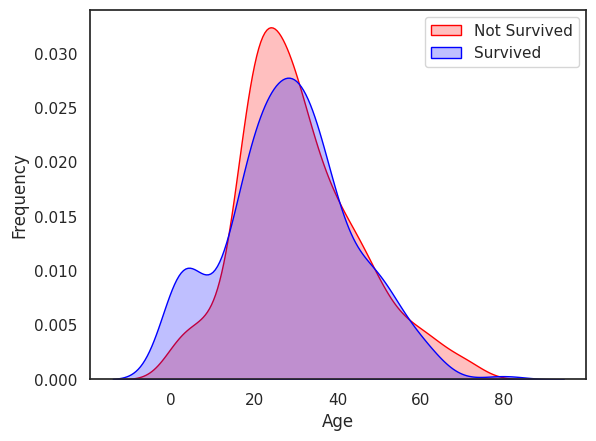

In [ ]:
# Explore Age distibution
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.

#### Fare

In [ ]:
dataset["Fare"].isnull().sum()

1

In [ ]:
# Fill Fare missing values with the median value  # Imputation
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Since we have one missing value , i decided to fill it with the median value which will not have an important effect on the prediction.

<ipython-input-24-2b85b20d935d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))


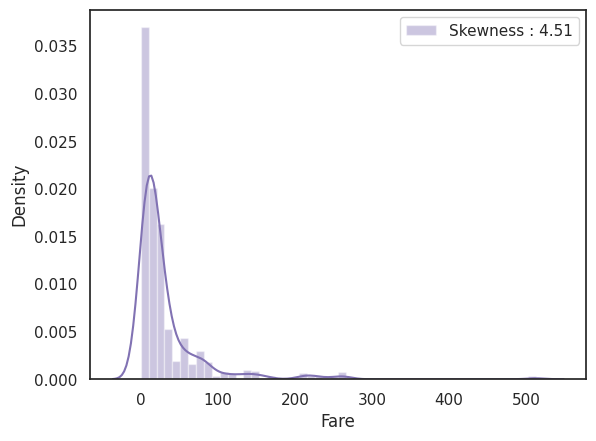

In [ ]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [ ]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

<ipython-input-26-35ec8efd2ddc>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))


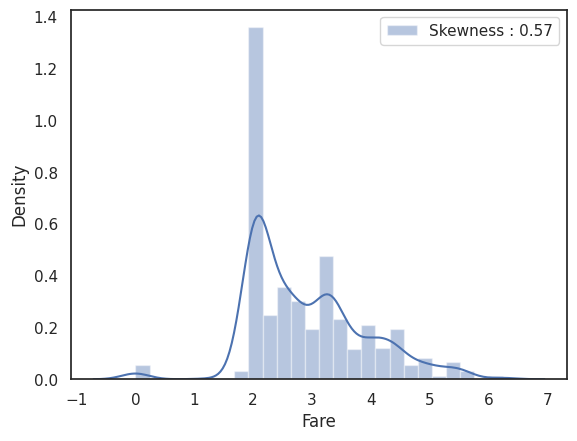

In [ ]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Skewness is clearly reduced after the log transformation

### 3.2 Categorical values

#### Sex

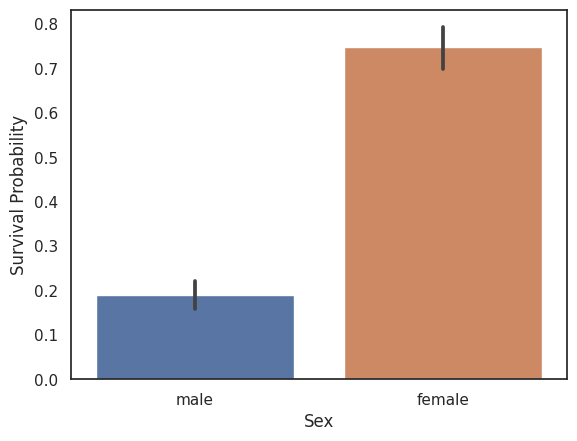

In [ ]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [ ]:
train[["Sex","Survived"]].groupby('Sex').mean()

Survived
Sex             
female  0.747573
male    0.190559

It is clearly obvious that Male have less chance to survive than Female.

So Sex, might play an important role in the prediction of the survival.

For those who have seen the Titanic movie (1997), I am sure, we all remember this sentence during the evacuation : "Women and children first".

#### Pclass

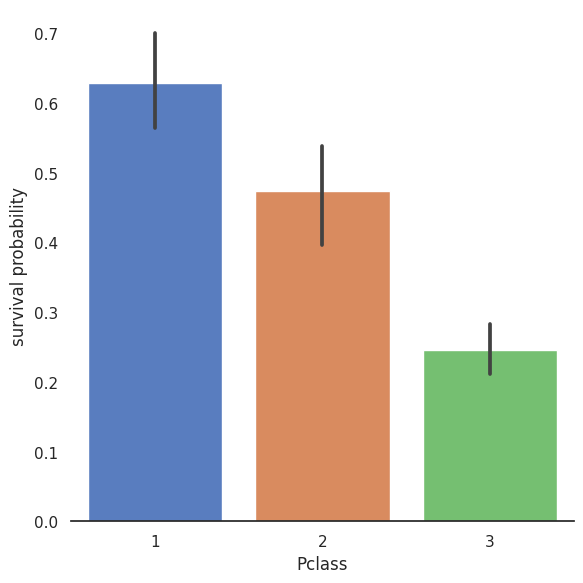

In [ ]:
# Explore Pclass vs Survived
g = sns.catplot(x="Pclass",y="Survived",data=train,kind="bar", height = 6 ,
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

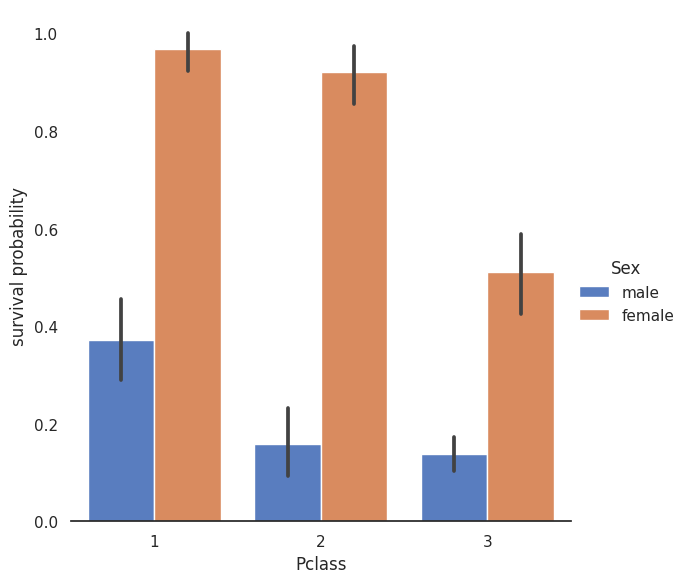

In [ ]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

This trend is conserved when we look at both male and female passengers.

#### Embarked

In [ ]:
dataset["Embarked"].isnull().sum()

2

In [ ]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

Since we have two missing values , i decided to fill them with the most fequent value of "Embarked" (S).

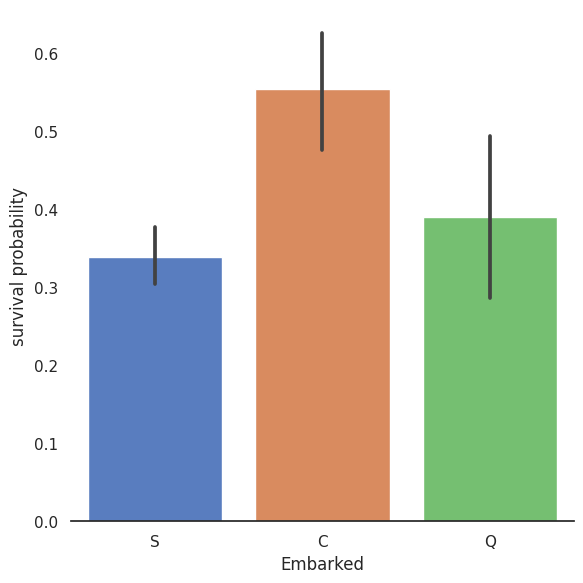

In [ ]:
# Explore Embarked vs Survived
g = sns.catplot(x="Embarked", y="Survived",  data=train,
                   height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passenger coming from Cherbourg (C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).

Let's see the Pclass distribution vs Embarked

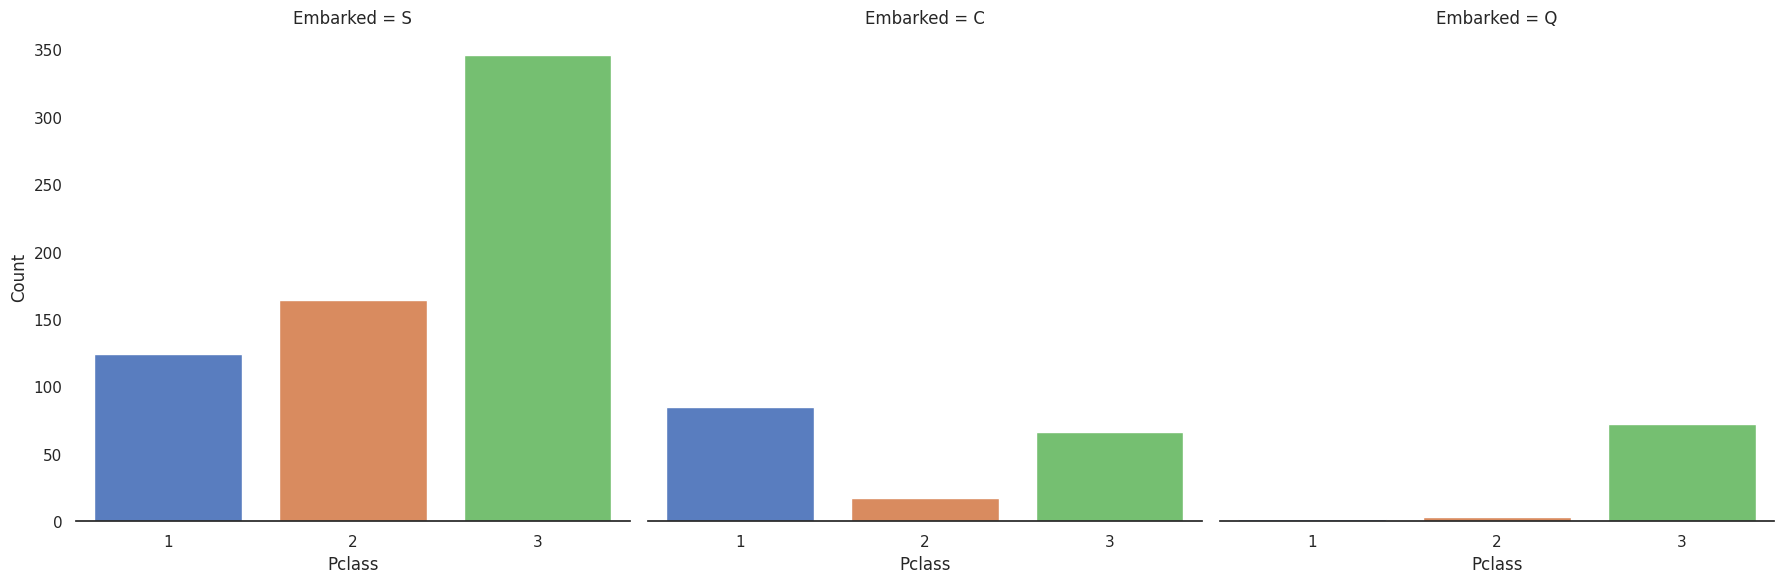

In [ ]:
# Explore Pclass vs Embarked
g = sns.catplot(x="Pclass", col="Embarked",  data=train,
                   height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

At this point, i can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.

## 4. Filling missing Values
### 4.1 Age

As we see, Age column contains 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

To adress this problem, i looked at the most correlated features with Age (Sex, Parch , Pclass and SibSP).

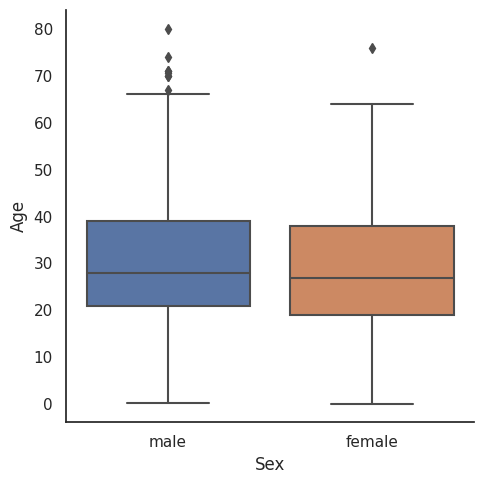

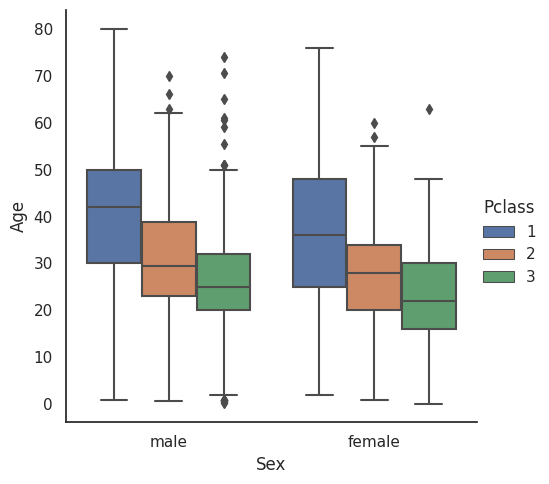

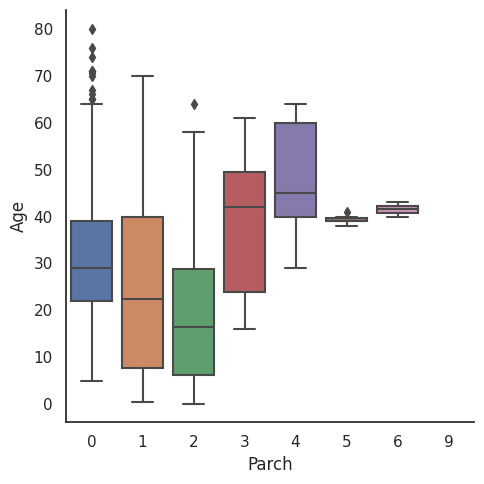

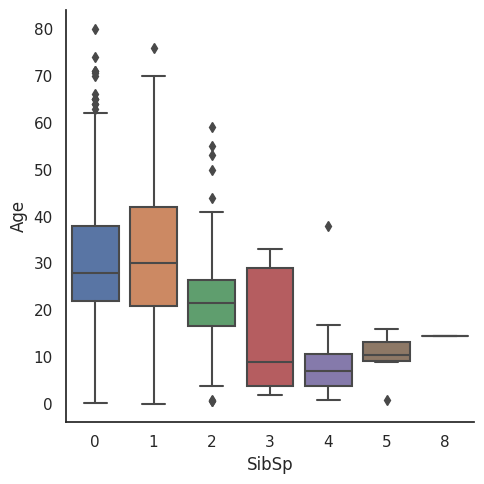

In [ ]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [ ]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

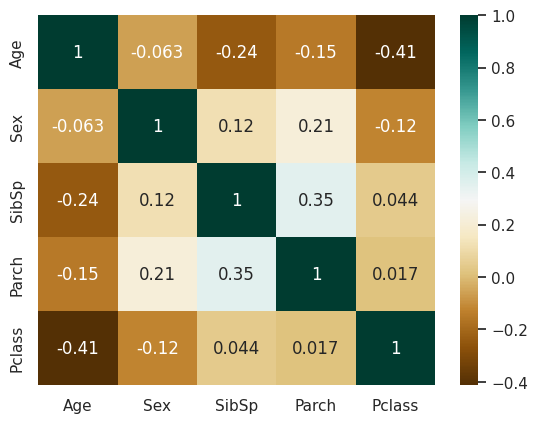

In [ ]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.

So, i decided to use SibSP, Parch and Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [ ]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med



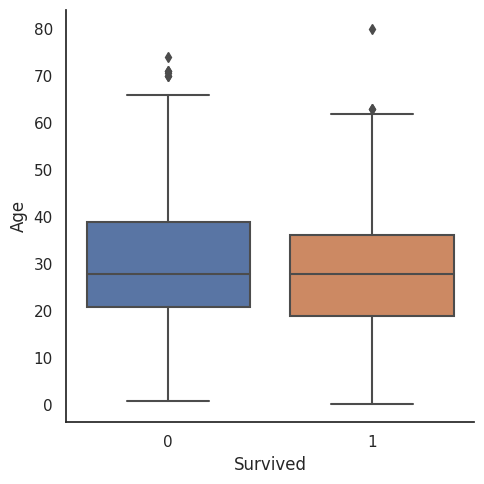

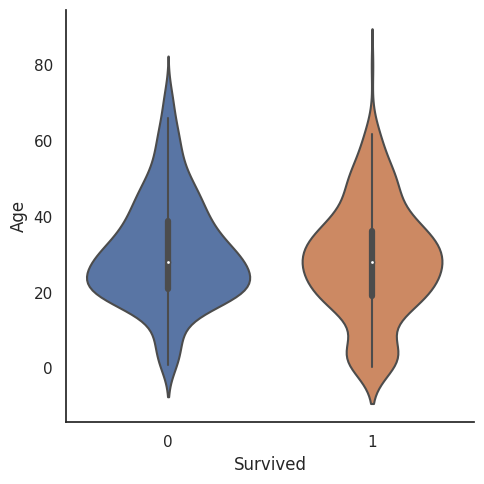

In [ ]:
g = sns.catplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.catplot(x="Survived", y = "Age",data = train, kind="violin")

No difference between median value of age in survived and not survived subpopulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

## 5. Feature engineering

### 5.1 Name/Title

In [ ]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains information on passenger's title.

Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

In [ ]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

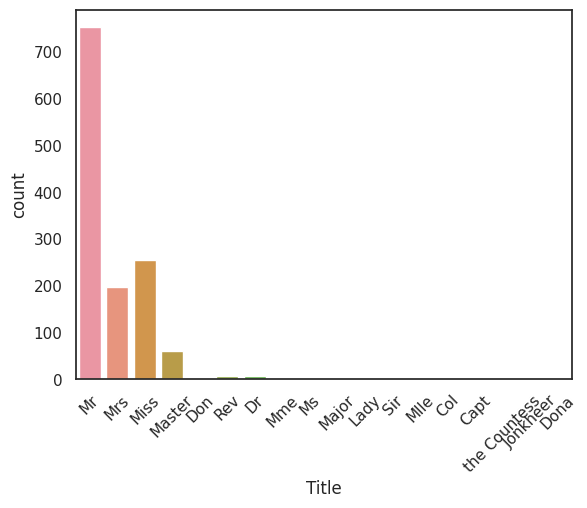

In [ ]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

In [ ]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

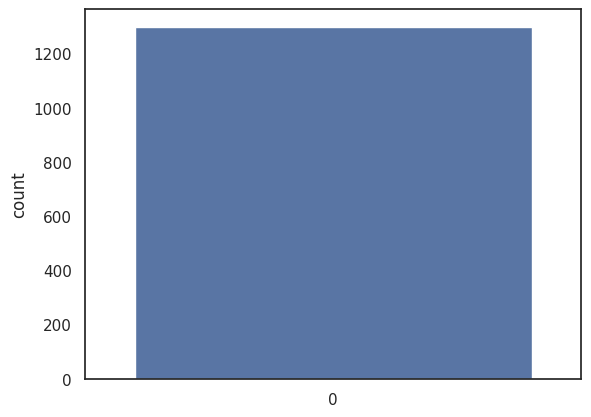

In [ ]:
g = sns.countplot(dataset["Title"])
##g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"], rotation=45)

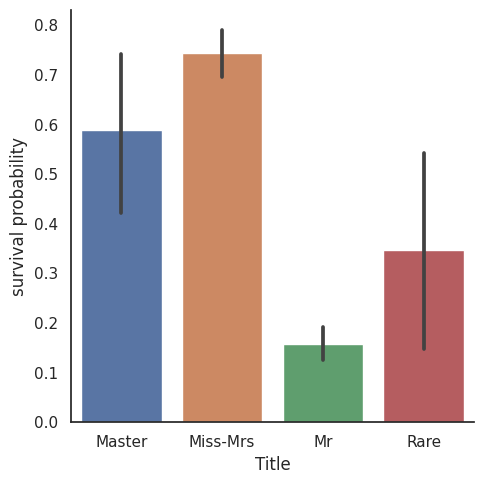

In [ ]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

"Women and children first"

It is interesting to note that passengers with rare title have more chance to survive.

In [ ]:
# Drop Name variable  # "Title" 얻고 "Name" 없앰
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

KeyError: ignored

### 5.2 Family size

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, I choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).

In [ ]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

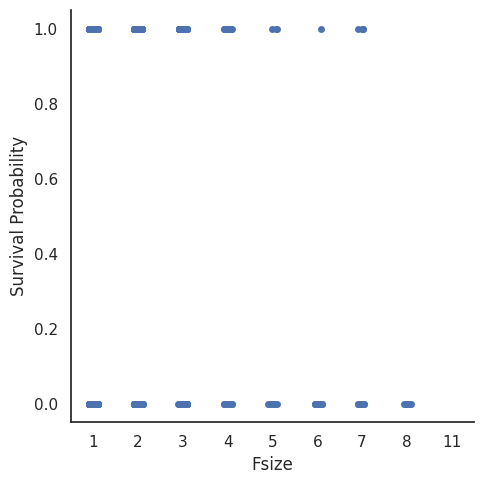

In [ ]:
g = sns.catplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

The family size seems to play an important role, survival probability is worst for large families.

Additionally, i decided to created 4 categories of family size.

In [ ]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

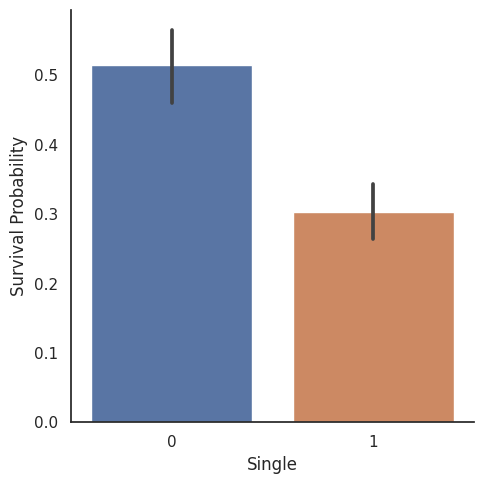

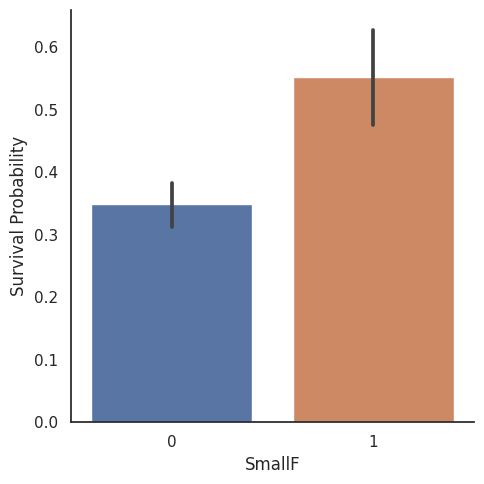

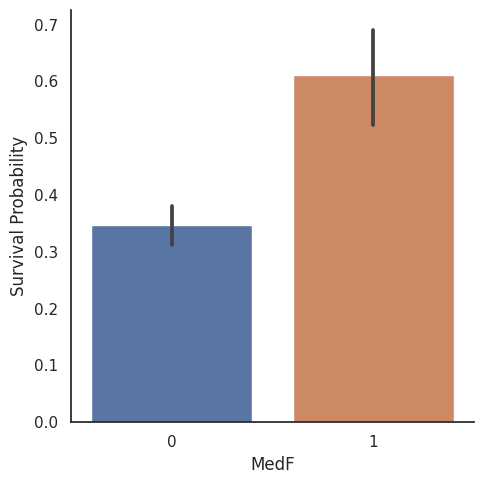

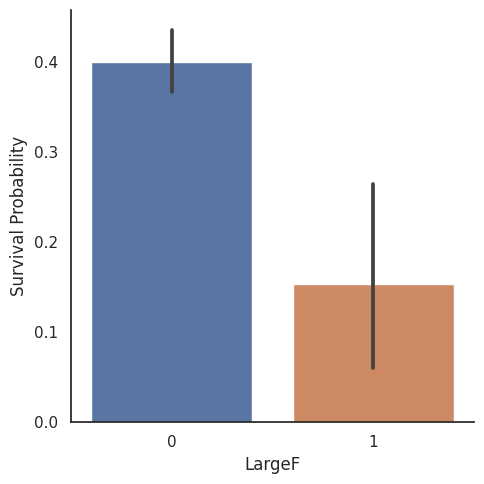

In [ ]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [ ]:
# convert to indicator values Title and Embarked #?
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [ ]:
dataset.head()

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch            Ticket  \
0            1       0.0       3    0  22.0      1      0         A/5 21171   
1            2       1.0       1    1  38.0      1      0          PC 17599   
2            3       1.0       3    1  26.0      0      0  STON/O2. 3101282   
3            4       1.0       1    1  35.0      1      0            113803   
4            5       0.0       3    0  35.0      0      0            373450   

       Fare Cabin  ...  SmallF  MedF  LargeF  Title_0  Title_1  Title_2  \
0  1.981001   NaN  ...       1     0       0        0        0        1   
1  4.266662   C85  ...       1     0       0        0        1        0   
2  2.070022   NaN  ...       0     0       0        0        1        0   
3  3.972177  C123  ...       1     0       0        0        1        0   
4  2.085672   NaN  ...       0     0       0        0        0        1   

   Title_3  Em_C  Em_Q  Em_S  
0        0     0     0     1  
1        0     1     0     0  
2        0     0     0     1  
3        0     0     0     1  
4        0     0     0     1  

[5 rows x 22 columns]

At this stage, we have 22 features.

### 5.3 Cabin

In [ ]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 missing values.

I supposed that passengers without a cabin have a missing value displayed instead of the cabin number.

In [ ]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])
dataset["Cabin"].head(30)

0     X
1     C
2     X
3     C
4     X
5     X
6     E
7     X
8     X
9     X
10    G
11    C
12    X
13    X
14    X
15    X
16    X
17    X
18    X
19    X
20    X
21    D
22    X
23    A
24    X
25    X
26    X
27    X
28    X
29    X
Name: Cabin, dtype: object

The first letter of the cabin indicates the Desk, I choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.

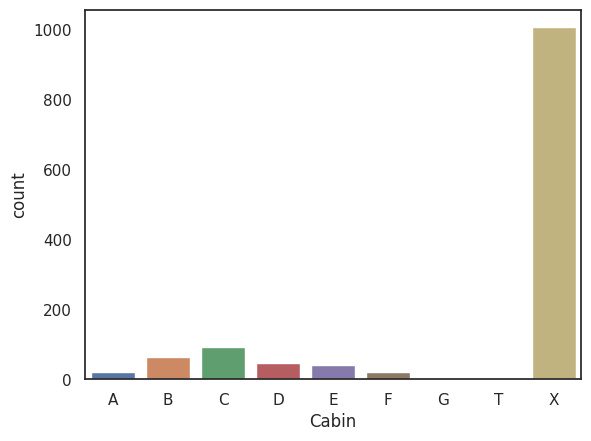

In [ ]:
#g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X']) -> Error
g = sns.countplot(data=dataset, x="Cabin", order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
plt.show()

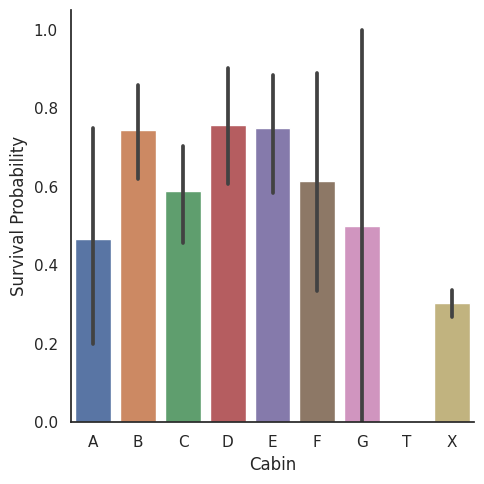

In [ ]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")


Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B, C, D, E and F.

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [ ]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So i decided to replace the Ticket feature column by the ticket prefixe. Which may be more informative.

In [ ]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()


0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [ ]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [ ]:
# Drop useless variables
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [ ]:
dataset.head()

Survived  Sex   Age  SibSp  Parch      Fare  Fsize  Single  SmallF  MedF  \
0       0.0    0  22.0      1      0  1.981001      2       0       1     0   
1       1.0    1  38.0      1      0  4.266662      2       0       1     0   
2       1.0    1  26.0      0      0  2.070022      1       1       0     0   
3       1.0    1  35.0      1      0  3.972177      2       0       1     0   
4       0.0    0  35.0      0      0  2.085672      1       1       0     0   

   ...  T_STONO  T_STONO2  T_STONOQ  T_SWPP  T_WC  T_WEP  T_X  Pc_1  Pc_2  \
0  ...        0         0         0       0     0      0    0     0     0   
1  ...        0         0         0       0     0      0    0     1     0   
2  ...        0         1         0       0     0      0    0     0     0   
3  ...        0         0         0       0     0      0    1     1     0   
4  ...        0         0         0       0     0      0    1     0     0   

   Pc_3  
0     1  
1     0  
2     1  
3     0  
4     1  

[5 rows x 67 columns]

## 6. MODELING

In [ ]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

<ipython-input-66-4ded5fa7d752>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis = 1,inplace=True)


In [ ]:
## Separate train features and label

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

<ipython-input-67-be88970b528a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


In [ ]:
# feature scaling using StandardScaler to ensure similar feature scales for improved model performance.
from sklearn.preprocessing import StandardScaler

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)

### 6.1 Simple modeling
#### 6.1.1 Cross validate models

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

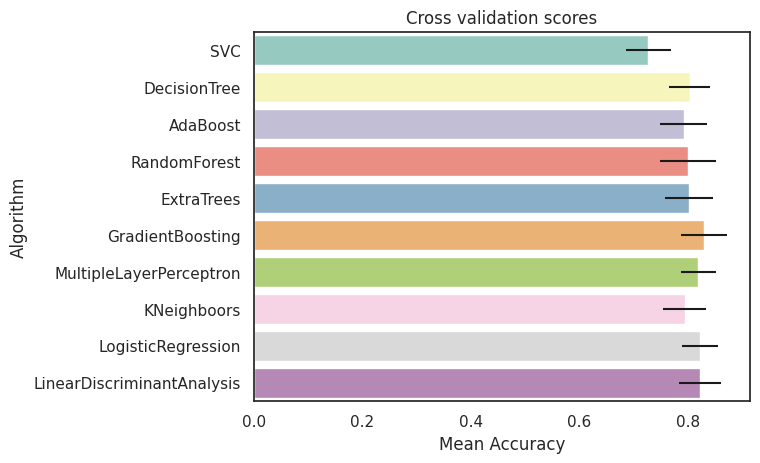

In [ ]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x = "CrossValMeans", y = "Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


I decided to choose the SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

#### 6.1.2 Hyperparameter tunning for best models

I performed a grid search optimization for AdaBoost, ExtraTrees , RandomForest, GradientBoosting and SVC classifiers.

I set the "n_jobs" parameter to 4 since i have 4 cpu . The computation time is clearly reduced.

But be carefull, this step can take a long time, i took me 15 min in total on 4 cpu.

- AdaBoost
- ExtraTrees
- RandomForest
- GradientBoosting
- SVC classifiers

In [ ]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]} #모든 경우의 수를 search to tune the parameter

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

# Best score
gsadaDTC.best_score_

NameError: ignored

In [ ]:
#ExtraTrees
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8297242083758938

The result 0.8297242083758938 represents the best score achieved by the ExtraTreesClassifier model after performing a grid search for optimal parameters using cross-validation.

In this context, the best score refers to the highest accuracy achieved by the model on the training data during the grid search process. It indicates the performance of the model with the selected set of hyperparameters on the given dataset.

A best score of 0.8297242083758938 suggests that the ExtraTreesClassifier model, trained with the best combination of parameter values found by the grid search, achieved an accuracy of approximately 82.97% on the training data. This score serves as an evaluation metric to compare and select the best model configuration among the tested parameter combinations.

In [ ]:
# RFC Parameters tunning
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342696629213483

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.8286006128702758

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### Now let's add 2 models for **feature_importances_**
- DecisionTreeClassifier
- LogisticRegression

In [ ]:
# DecisionTreeClassifier
DTC = DecisionTreeClassifier()

dtc_param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5]
}



In [ ]:
# LogisticRegression
logreg = LogisticRegression(max_iter=1000)

logreg_param_grid = {
    "penalty": ['l2', 'none'],
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}




#### 6.1.3 Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

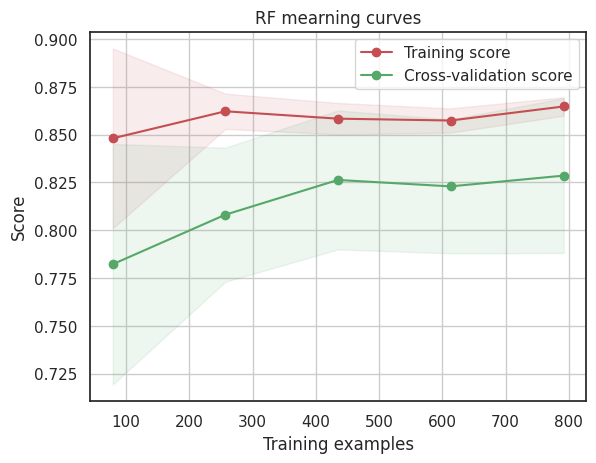

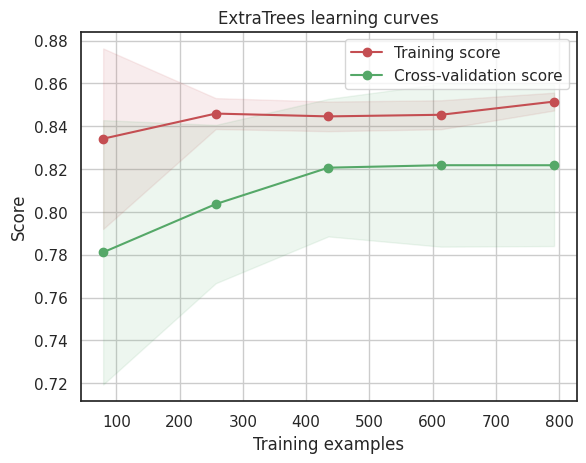

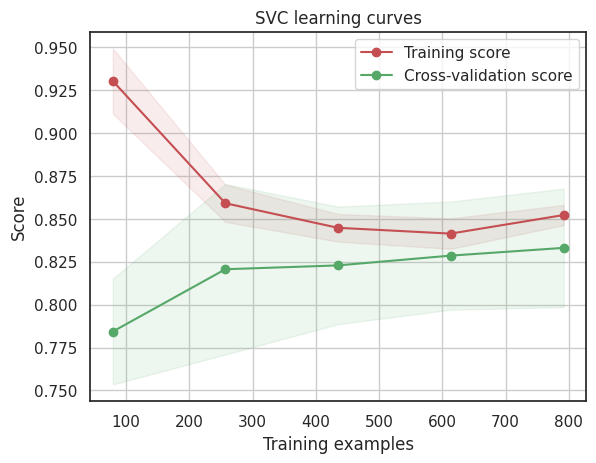

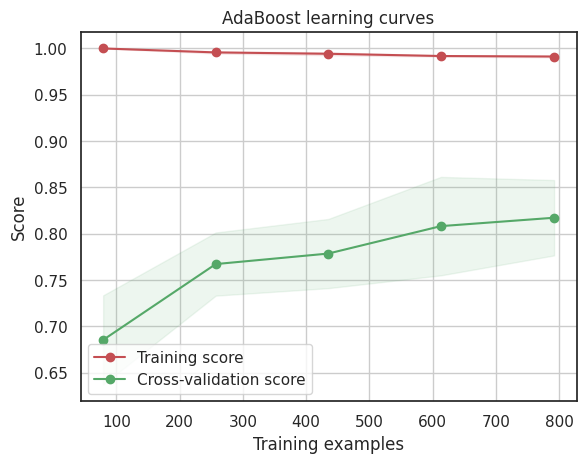

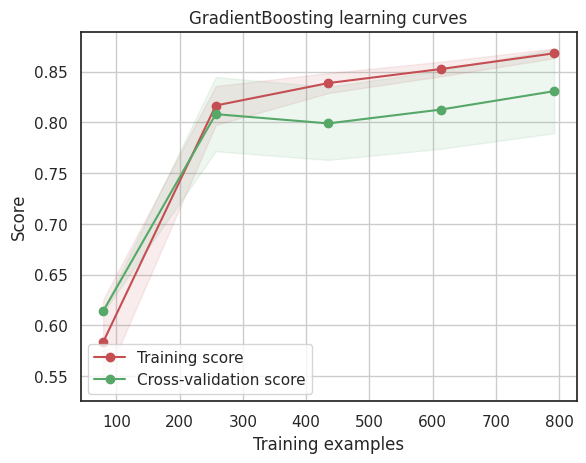

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)



GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

### 6.2 Ensemble modeling
#### 6.2.1 Correlation Analysis


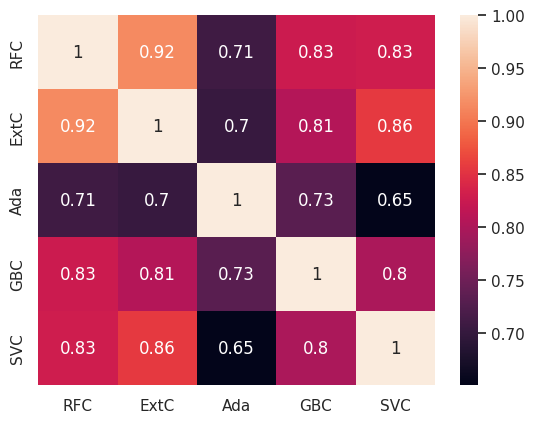

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

The prediction seems to be quite similar for the 5 classifiers except when Adaboost is compared to the others classifiers.

The 5 classifiers give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.

#### 6.2.2 Combining models

I choosed a voting classifier to combine the predictions coming from the 5 classifiers.

I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)
print(votingC)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=3,
                                                     min_samples_leaf=3,
                                                     min_samples_split=10)),
                             ('extc',
                              ExtraTreesClassifier(max_features=3,
                                                   min_samples_leaf=3,
                                                   min_samples_split=10,
                                                   n_estimators=300)),
                             ('svc', SVC(C=10, gamma=0.01, probability=True)),
                             ('adac',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                 learning_rate=0.3,
                                                 n_estimators=2,


### 6.3 Prediction
#### 6.3.1 Predict and Submit results

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

print(results)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


## 7. Built-in **Feature importance**

In order to see the most informative features for the prediction of passengers survival, I displayed the feature importance for 6 classifiers.
- AdaBoost
- ExtraTrees
- RandomForest
- GradientBoosting
- DecisionTree
- Logistic regression

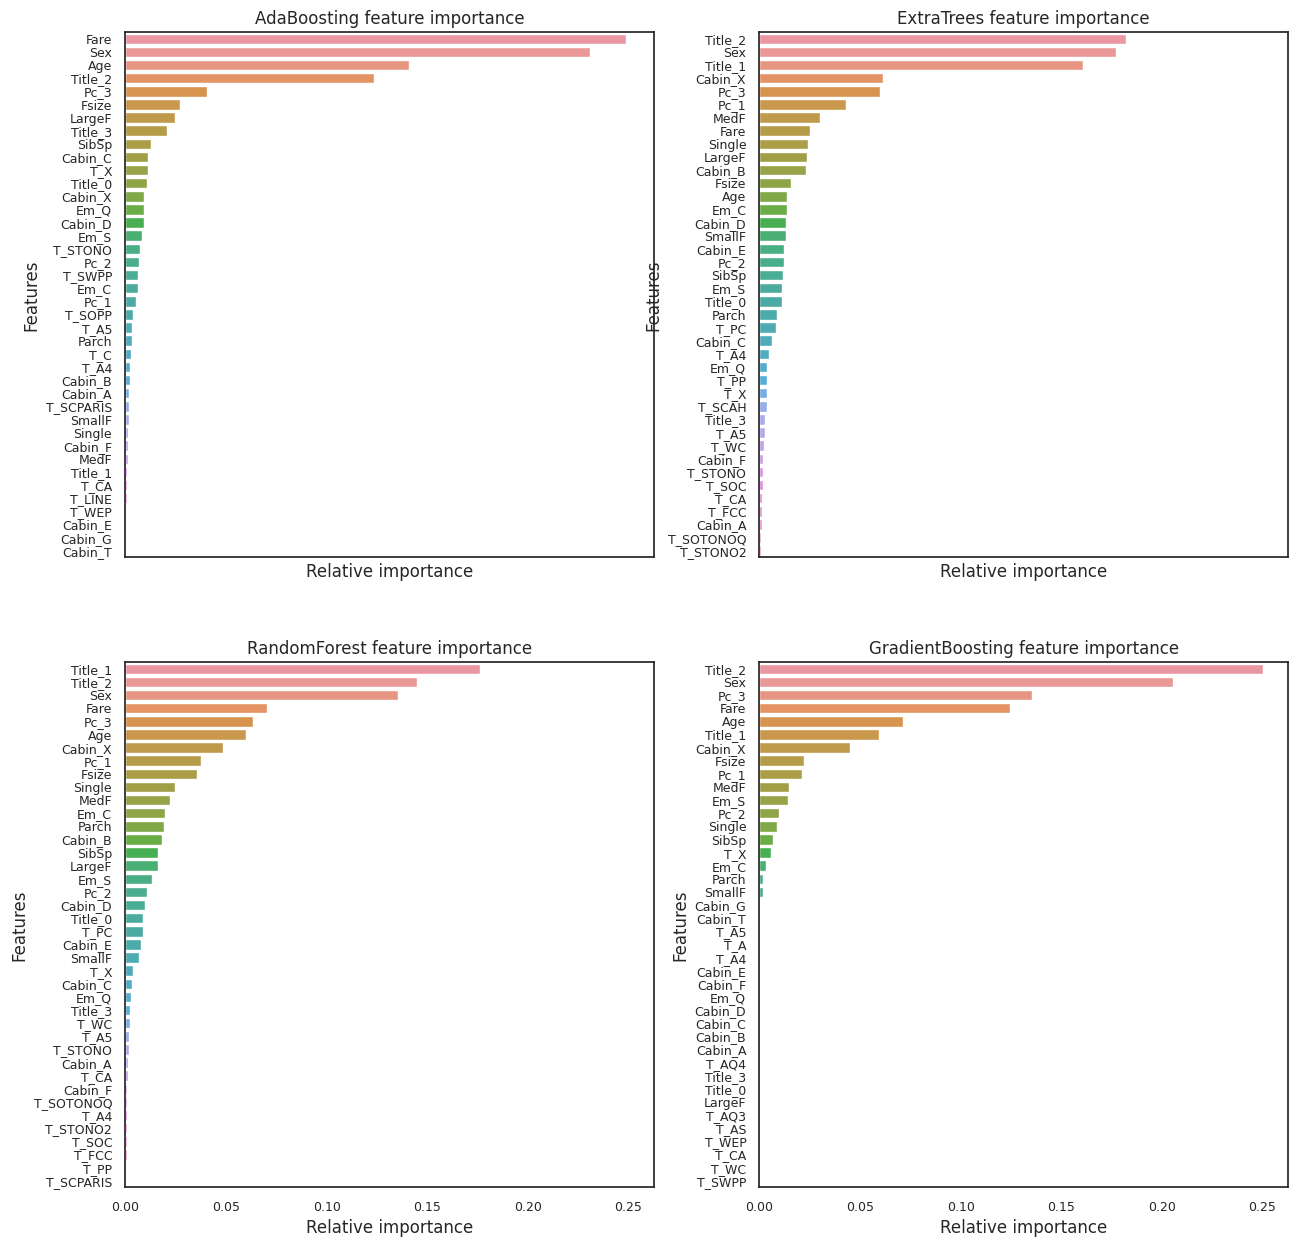

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

I plot the feature importance for the 4 classifiers (Adaboost, ExtraTrees, RandomForest and GradientBoosting).

We note that the six classifiers have different top features according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the classification , for example 'Fare', 'Title_1', 'Title_2', 'Age', 'Sex' and
'Pc_3'.

Title_2 which indicates the Mrs/Mlle/Mme/Miss/Ms category is highly correlated with Sex.

We can say that:

- Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.

- Sex and Title_1 (Mrs/Mlle/Mme/Miss/Ms) and Title_2 (Mr) refer to the gender.

- Age and Title_0 (Master) refer to the age of passengers.

- Fsize, LargeF, MedF, Single refer to the size of the passenger family.

**According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex and the social standing of the passengers.**

## 8. PFI

**Permutation Feature Importance (PFI):**


Permutation Feature Importance (PFI) is a powerful technique used in machine learning to understand the importance of each feature (input variable) in predicting the target variable for tabular datasets. It provides valuable insights into which features contribute the most to the model's performance, enabling feature selection, model interpretability, and data quality assessment. PFI's importance rankings help prioritize feature engineering efforts, compare models, and address biases, ultimately enhancing model performance, interpretability, and overall trustworthiness in critical decision-making applications.

**How PFI Works:**

PFI works by measuring the impact of shuffling the values of a single feature on the model's performance. The process involves taking a trained model and randomly permuting the values of one feature while leaving the others unchanged. The model's performance is then evaluated with the permuted feature, and the difference in performance compared to the original feature is recorded.

**What You Can Get from PFI:**

PFI generates a numerical score for each feature, indicating its importance to the model's predictions. Features with higher PFI scores are considered more important, as shuffling their values resulted in a significant drop in the model's performance. Conversely, features with lower scores have less impact on the model's predictions and may be less relevant.

**Benefits of Using PFI:**

* Feature Selection: PFI helps in feature selection by highlighting the most influential features, enabling data scientists to focus on those that matter most, potentially simplifying the model and improving interpretability.

* Model Understanding: PFI offers insights into the relationships between features and target variables, promoting a better understanding of the underlying data and model behavior.

* Detecting Data Issues: PFI can reveal features that have little or no predictive power, which may indicate data quality issues or noisy data.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Scale the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Convert the scaled data back into a DataFrame with the original feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Modeling step with PFI
random_state = 2
classifiers = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state, max_iter=500),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state, solver='saga', penalty='l1', max_iter=500),
    LinearDiscriminantAnalysis()
]

pf_importances = []  # To store permutation importances for each classifier

for classifier in classifiers:
    # Fit the classifier
    classifier.fit(X_train, Y_train)

    # Perform permutation feature importance
    result = permutation_importance(classifier, X_train_scaled, Y_train, n_repeats=10, random_state=random_state, n_jobs=4)
    pf_importances.append(result.importances_mean)

# Create DataFrame for PFI results
pfi_res = pd.DataFrame(pf_importances, columns=X_train.columns)

# Add a new column to store the mean PFI for each classifier
pfi_res['Mean_PFI'] = pfi_res.mean(axis=1)

# Now you have the PFI results in the pfi_res DataFrame
print(pfi_res)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


        Sex       Age     SibSp     Parch      Fare     Fsize    Single  \
0  0.000568 -0.005562  0.000908 -0.003405 -0.002951  0.002157 -0.001703   
1  0.000000  0.000000  0.003065  0.000000  0.008513 -0.000454  0.002270   
2  0.124631  0.002497  0.000000  0.000114  0.010216  0.001476  0.000000   
3  0.020885 -0.002384  0.017707 -0.000454  0.000341  0.007378 -0.000681   
4  0.065380  0.000568 -0.003405  0.006810  0.002270  0.005221  0.001703   
5  0.020772 -0.000908 -0.000681  0.000000  0.002724  0.000000  0.000000   
6  0.007037  0.001703 -0.017594 -0.003973 -0.016345  0.001816 -0.044608   
7  0.001249 -0.000681  0.019296  0.002497  0.004427  0.019183  0.000000   
8  0.024177 -0.000454  0.016118  0.005108  0.003065  0.026901  0.000000   
9  0.226334  0.000000 -0.000114 -0.000114 -0.000114  0.000000 -0.002838   

     SmallF      MedF    LargeF  ...  T_STONO2  T_STONOQ    T_SWPP      T_WC  \
0  0.000000  0.000227  0.002043  ...  0.000000       0.0  0.000000  0.000000   
1  0.000000  0

In [ ]:
# Calculate the mean and standard deviation of the permutation feature importances
pfi_res_mean = pfi_res.mean(axis=0)
pfi_res_std = pfi_res.std(axis=0)

# Create a DataFrame to store the results
pfi_summary = pd.DataFrame({
    'Weight': pfi_res_mean,
    'Std_Dev': pfi_res_std
})

# Add the 'Feature' column to the DataFrame
pfi_summary['Feature'] = pfi_summary.index

# Sort the DataFrame based on the 'Weight' column in descending order
pfi_summary.sort_values(by='Weight', ascending=False, inplace=True)

# Format the 'Weight' column to include ± std_dev
pfi_summary['Weight'] = pfi_summary.apply(lambda x: f"{x['Weight']:.4f} ± {x['Std_Dev']:.4f}", axis=1)

# Drop the 'Std_Dev' column as it is no longer needed
pfi_summary.drop('Std_Dev', axis=1, inplace=True)

# Reset the index of the DataFrame
pfi_summary.reset_index(drop=True, inplace=True)

# Display the formatted PFI results
print(pfi_summary)

              Weight  Feature
0    0.0635 ± 0.0800  Title_2
1    0.0491 ± 0.0734      Sex
2    0.0131 ± 0.0257     Pc_3
3    0.0114 ± 0.0185   LargeF
4    0.0077 ± 0.0064  Cabin_E
..               ...      ...
62  -0.0014 ± 0.0076  Cabin_C
63  -0.0016 ± 0.0047     Em_Q
64  -0.0021 ± 0.0135  Cabin_X
65  -0.0033 ± 0.0137     Pc_1
66  -0.0046 ± 0.0141   Single

[67 rows x 2 columns]


### **Interpretation**

Interpreting the result of permutation feature importance (PFI) involves understanding the impact of each feature on the model's performance. The PFI measures the importance of each feature by evaluating how much the model's performance (accuracy in this case) drops when the values of that feature are randomly shuffled. A larger drop in performance indicates a more critical feature for the model's predictions.

<br>

**Positive Weight**: A positive weight indicates that increasing the values of the corresponding feature positively affects the model's performance. In this case, Title_2 has the highest positive weight, meaning that it is the most important feature for the model's predictions. Similarly, Sex, Pc_3, and LargeF also have positive weights and contribute significantly to the model's accuracy.

**Negative Weight**: A negative weight indicates that increasing the values of the corresponding feature has a negative impact on the model's performance. Features like Cabin_C, Em_Q, Cabin_X, Pc_1, and Single have negative weights, suggesting that these features are less relevant or potentially noisy for the model's predictions.

**Magnitude of Weight**: The absolute magnitude of the weight is also essential. Larger absolute values indicate greater importance. For example, Title_2 with a weight of 0.0635 (mean) has higher importance compared to Cabin_X with a weight of -0.0021.

**Standard Deviation (±)**: The standard deviation associated with each weight provides an idea of the uncertainty or variability in the PFI estimation. A larger standard deviation means more variability in the permutation results. For example, Title_2 has a higher standard deviation (0.0800) compared to Cabin_X (0.0135).

## 9. SHAP

### 9.1 Shapley value
Shapley value is a model-agnostic tool, it could be applied to many kinds of Machine Learning models.

The definition of $x_{p}$'s Shapley value is: comparing with mean value of prediction, $x_{p}$'s contribution on the prediction of specific a data instance is $\phi_j$

For linear models, we could calculate prediction using feature values, $x_{p}$, here shows a data instance:

$$\hat{f}(x)=\beta_0+\beta_{1}x_{1}+\ldots+\beta_{p}x_{p}$$
$\beta_{p}$ are weight (coeffiecient) corresponding to the feature values $x_{p}$.

The contribution for feature $x_{p}$ on $\hat{f}(x)$ is:

$$\phi_j(\hat{f})=\beta_{j}x_j-E(\beta_{j}X_{j})=\beta_{j}x_j-\beta_{j}E(X_{j})$$
If we add all the $\phi_j$ of one data distance, it equals the prediction of x minus average prediction.

$$\begin{align*}\sum_{j=1}^{p}\phi_j(\hat{f})=&\sum_{j=1}^p(\beta_{j}x_j-E(\beta_{j}X_{j}))\\=&(\beta_0+\sum_{j=1}^p\beta_{j}x_j)-(\beta_0+\sum_{j=1}^{p}E(\beta_{j}X_{j}))\\=&\hat{f}(x)-E(\hat{f}(X))\end{align*}$$

The Shapley value of a feature value x~j~ is its contribution to the payout, weighted and summed
over all possible feature value combinations:

$$\phi_j(val)=\sum_{S\subseteq\{x_{1},\ldots,x_{p}\}\setminus\{x_j\}}\frac{|S|!\left(p-|S|-1\right)!}{p!}\left(val\left(S\cup\{x_j\}\right)-val(S)\right)$$

Imagine that some features randomly enter a box and generate a prediction value, when adding a new feature, how much the prediction will change on average compared to original features coalition? That's what shapley value is.  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 23.7 MB/s eta 0:00:00


In [ ]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Remind the feature names

In [ ]:
dataset.head()

Survived  Sex   Age  SibSp  Parch      Fare  Fsize  Single  SmallF  MedF  \
0       0.0    0  22.0      1      0  1.981001      2       0       1     0   
1       1.0    1  38.0      1      0  4.266662      2       0       1     0   
2       1.0    1  26.0      0      0  2.070022      1       1       0     0   
3       1.0    1  35.0      1      0  3.972177      2       0       1     0   
4       0.0    0  35.0      0      0  2.085672      1       1       0     0   

   ...  T_STONO  T_STONO2  T_STONOQ  T_SWPP  T_WC  T_WEP  T_X  Pc_1  Pc_2  \
0  ...        0         0         0       0     0      0    0     0     0   
1  ...        0         0         0       0     0      0    0     1     0   
2  ...        0         1         0       0     0      0    0     0     0   
3  ...        0         0         0       0     0      0    1     1     0   
4  ...        0         0         0       0     0      0    1     0     0   

   Pc_3  
0     1  
1     0  
2     1  
3     0  
4     1  

[5 rows x 67 columns]

### 9.2 Model Interpretation by SHAP

#### 9.2.1 Force plot
Individual data

The influence on the current prediction can be understood by the force plot. The red-colored features positively influence the prediction (tends to increase the predicted value), whereas the blue-colored features  have  a  negative  influence (tends to decrease  the  pre-dicted value). The red-colored features shift the prediction towards the right side (close to 1) from the base value, and the blue-colored features try to shift the  prediction towards the left side from the base value (close to 0).

In [ ]:
# xgb 모델 사용
from xgboost import XGBRegressor, plot_importance
model = XGBRegressor()
model.fit(X_train, Y_train)

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

From this plot, we can understand how much each feature impacted to the prediction score.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[300,:], X_train.iloc[300,:])

Overall Data

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train)

In this plot, passengers are sorted by the similarity. So similar passengers (which means having close feature value from the view point of data) are gathered. From this plot ,we can roughly understand what kind of passenger groups are there and its volume.

#### 9.2.2 Dependency Plot
By using this Dependency Plot, we can visualize the affection between variables to the predictions score. When you specify 1 feature, This Dependenc_Plot function will automatically pick up another feature which have the strongest dependency with the selected feature. This is useful!

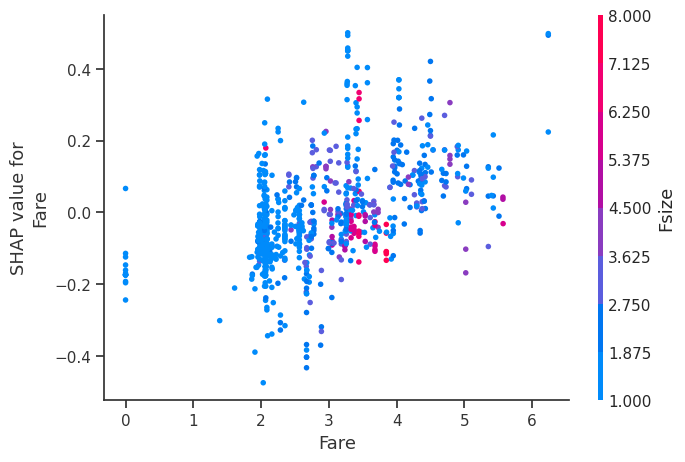

In [ ]:
shap.dependence_plot("Fare",shap_values, X_train)

From this plot, we can understand high fare have raised chance of survive.

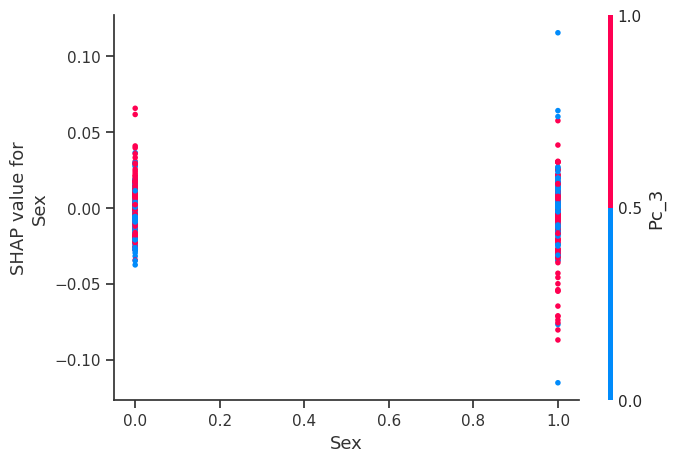

In [ ]:
shap.dependence_plot("Sex",shap_values, X_train)

From this plot, we can understand Sex = Women (Sex = 0) have raised chance of survive.

#### 9.2.3 Summary Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


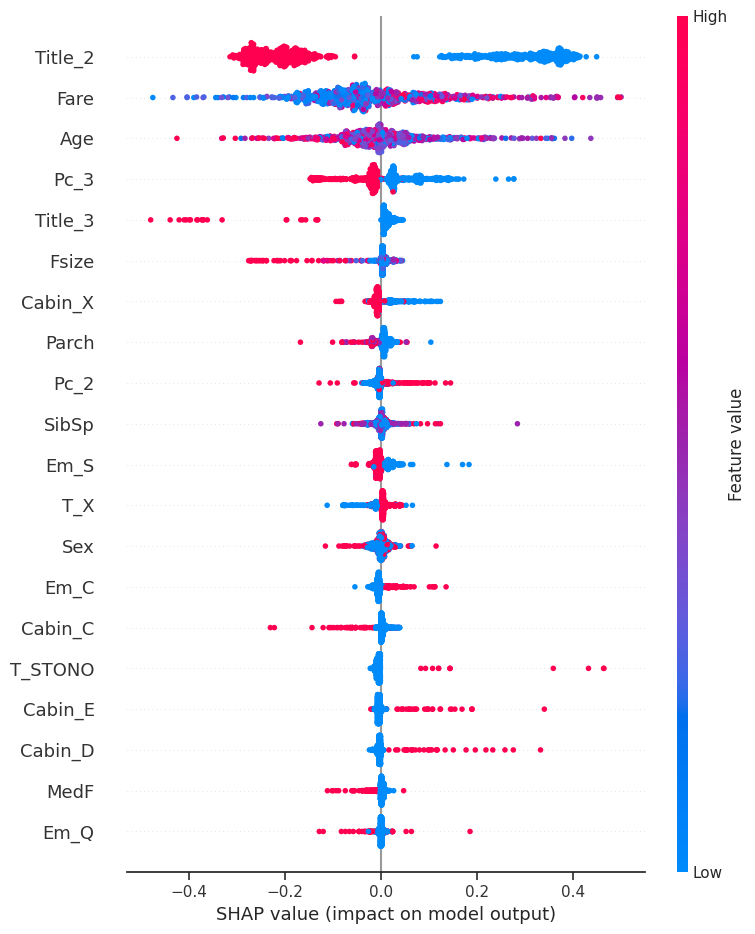

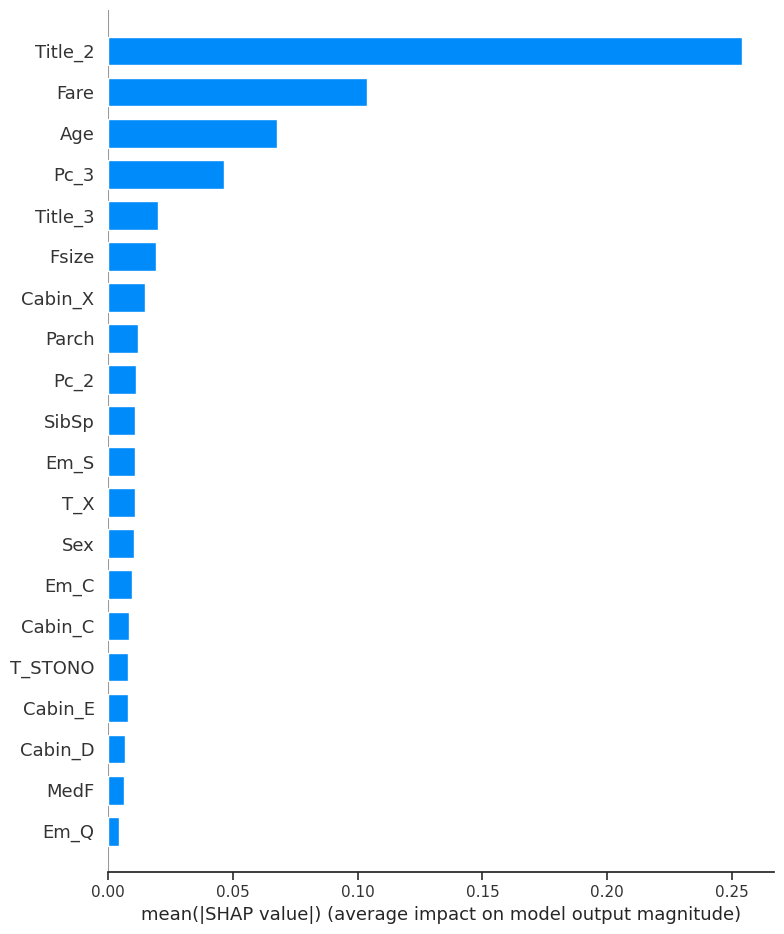

In [ ]:
shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

This Order is different from Feature Importance. How can we choose Feature Importance and SHAP in the usual business scenario? If SHAP value is more intuitive for human than Feature Importance, is there any meaning to use Feature Importance?